Homework 2: Graph Neural Network for chemistry

2) Graph neural networks for molecules (GCN)
- experiment GCN from the deepchem python library
- understand the GCN structure and learning (see GNN course slides)
- test it on several supervised datasets, in order the make node classification or graph classification
- evaluate (explain the measures) and discuss the results


In [2]:
!pip install --pre deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 49.5 MB/s eta 0:00:00


In [3]:
!pip install tensorflow==2.13.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      S

We make a first test the DeepChem library with the code mentioned in the tutorial. We load the Tox21 dataset with the featurizer 'GraphConv'.

In [1]:
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
[09:58:12] WARNING: not removing hydrogen atom without neighbors
[09:58:29] WARNING: not removing hydrogen atom without neighbors


In [53]:
print(tasks)

['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']


Train the graph convolutional network for classification with GraphConvModel

In [52]:
n_tasks = len(tasks)
model = dc.models.GraphConvModel(n_tasks, mode='classification', batch_normalize=False)
model.fit(train_dataset, nb_epoch=50)

ValueError: cannot reshape array of size 200 into shape (12,2)

Evaluate the performance of the model. We use the metric ROC-AUC score (tradeoff between precision and recall).

In [ ]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print('Training set score:', model.evaluate(train_dataset, [metric], transformers))
print('Test set score:', model.evaluate(test_dataset, [metric], transformers))

Training set score: {'roc_auc_score': 0.9655462890186256}
Test set score: {'roc_auc_score': 0.719777646352354}


Let's use the SIRTUIN6 Small Molecules dataset, for classification, which includes 100 molecules with descriptors to determine the candidate inhibitors of a target protein. The molecules are grouped based on low- and high-BFE which we use for the classification.
Link to the dataset:
https://archive.ics.uci.edu/dataset/748/sirtuin6+small+molecules-1

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#import sirtuin6 dataset
df = pd.read_csv('SIRTUIN6.csv')
X = df.drop('Class', axis=1).values
y = (df['Class'] == 'High_BFE').astype(int)

In [55]:
#split data between train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

train_dataset = dc.data.NumpyDataset(X_train_scaled, y_train)
test_dataset = dc.data.NumpyDataset(X_test_scaled, y_test)

In [56]:
n_features = X_train.shape[1]
model = dc.models.MultitaskClassifier(n_tasks=1, n_features=n_features, layer_sizes=[64, 32], dropout=0.2)

#train the model
model.fit(train_dataset, nb_epoch=50)

0.5973838424682617

In [57]:
y_pred_proba = model.predict(test_dataset)

In [59]:
#we convert the probabilities to class predictions to solve issues with shape
y_pred_classes = np.argmax(y_pred_proba, axis=2)
y_pred_classes = y_pred_classes.flatten()
y_test_flat = y_test.flatten()

We perform evaluation on the regular measures for models with the function classification_report from sklearn.metrics. It covers precision, recall, f1-score and support for the classes.  
- Precision : measures the accuracy of positive predictions.
- Recall : measures the ability of the model to find all positive samples.
- f1-score : mean of precision and recall.
- suport : number of true samples in each class.


In [61]:
print(classification_report(y_test_flat, y_pred_classes))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.90      0.75      0.82        12

    accuracy                           0.80        20
   macro avg       0.80      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20



The accuracy is evidence that the model correctly classifies with 80% of the samples.

Observing precision, recall and the f1_score allows us to individually assess the quality of the classification over each of the possible values predicted.
We notice High_BFE (class 1) has a higher precision rate that Low_BFE (class 0) while invertly High_BFE has a lower recall rate.
The precision suggests that the model incorrectly classifies low_BFE as high_BFE more often. On the contrary the recall suggests there are fewer false negatives for low_BFE.

We can also print the confusion matrix which compares the predicted labels with the true labels.

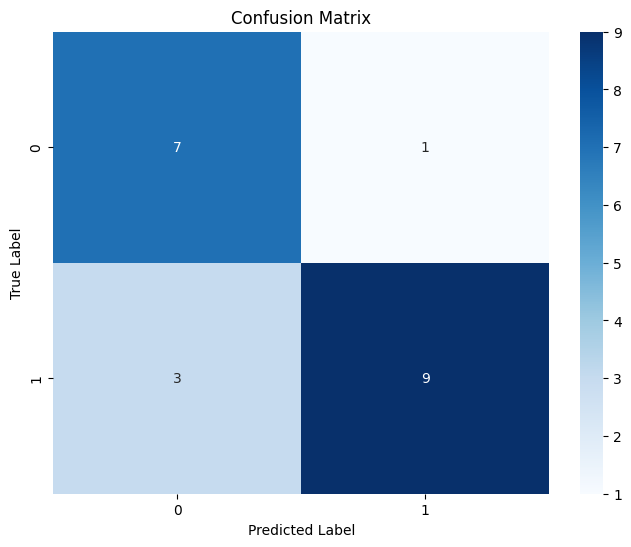

In [64]:
cm = confusion_matrix(y_test_flat, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

To read the confusion matrix in this case, we could look at the false positives (1). The false positives are especially important in this context of drug molecules where we want to minimize the number of times we wrongfully classify a molecule as a class it doesn't belong.